# GAN - first tries

We are implementing a simple feed-forward GAN architecture on MNIST - just to get the feeling right.

## Loading data

In [238]:
from tensorflow.keras.datasets import mnist
import tensorflow as tf
import numpy as np

In [239]:
(train_data,_),(test_data,_) = mnist.load_data()

In [240]:
# The more the merrier :-)
# Remember, this is unsupervised learning, so "holdout" and such makes less sense
data = np.concatenate((train_data,test_data),axis=0)

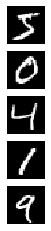

In [241]:
import matplotlib.pyplot as plt

example_count = 5

for ex in range(example_count):
    plt.subplot(5, example_count//5, ex+1)
    plt.imshow(data[ex], interpolation="nearest", cmap="gray")
    plt.axis("off")

plt.show()

In [242]:
# Normalization betwenn -1 and 1 !!!!
quasi_mean = data.max()/2 # Max is always 255, so this works ok.
data = (data.astype(np.float32)-quasi_mean)/quasi_mean

In [243]:
# Flattening of the image vectors
data = data.reshape(data.shape[0],-1)

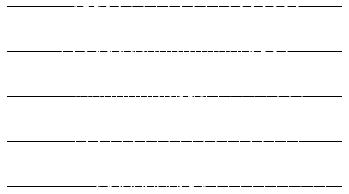

In [244]:
# Just to get the feeling, how bad this representation is...

example_count = 5

for ex in range(example_count):
    plt.subplot(5, example_count//5, ex+1)
    plt.imshow(data[ex].reshape(1,-1), interpolation="nearest", cmap="gray")
    plt.axis("off")

plt.show()

## Parameters

### Training parameters

We will be forced to do manual batching here, so we have to calcculate the number of batches manually, and iterate on a per batch basis.

In [245]:
EPOCHS = 30
BATCH_SIZE = 200
HALF_BATCH = BATCH_SIZE // 2
BATCH_NUM = (data.shape[0] // BATCH_SIZE)
if data.shape[0] % BATCH_SIZE:
    BATCH_NUM+=1
Z_DIM = 100


### Model parameters

In [246]:
GENERATOR_L1_DIM = 256
GENERATOR_L2_DIM = 512
GENERATOR_L3_DIM = 1024

DISCRIMINATOR_L1_DIM = 512
DISCRIMINATOR_L2_DIM = 256

LEAKY_ALPHA = 0.2

## Model building

In [247]:
from tensorflow.keras.optimizers import Adam

# Some empirically set values. 
# It might well be worth experimenting with newer optimizers / settings
optimizer = Adam(lr=2e-4, beta_1=0.5)

### Generator

In [248]:
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Flatten
from tensorflow.keras.models import Model
from keras import backend as K
from keras.utils import plot_model

Model: "functional_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
dense_59 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_42 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_60 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_43 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_61 (Dense)             (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_44 (LeakyReLU)   (None, 1024)            

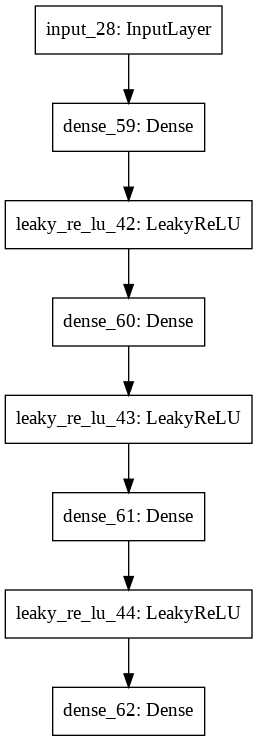

In [249]:
### Define the generator!
#########################
# We use FUNCTIONAL API!


# The generator always gets a noise vector as input
noise_input = Input(shape = (Z_DIM,))


###########################################################################
# Define the first layer of the fully connected network, without activation!
# Use the parameters defined with capital letter constants in the cells above for node counts!
g_layer_1 = Dense(GENERATOR_L1_DIM, activation=None)(noise_input)

# Define a non-linearity, namely leaky relu on this layer!
# We use LeakyReLU for avoiding sparsity - other options are viable also, just not normal relu
# Use the alpha value defined in constants above!
g_layer_1_nonlin = LeakyReLU(alpha=LEAKY_ALPHA)(g_layer_1)

# You can do this as one layer, but now we do it in two. Does not matter.
# Not required "Life's difficult when we are on layers!"

# Repeat the process two more times!
g_layer_2 = Dense(GENERATOR_L2_DIM, activation=None)(g_layer_1_nonlin)
g_layer_2_nonlin =  LeakyReLU(alpha=LEAKY_ALPHA)(g_layer_2)


g_layer_3 = Dense(GENERATOR_L3_DIM, activation=None)(g_layer_2_nonlin)
g_layer_3_nonlin = LeakyReLU(alpha=LEAKY_ALPHA)(g_layer_3)

#############################################################################
# The output of the generator is a flattened image
# Remeber, we normalized everything between -1 and +1, so what is a nice nonlinearity, bounded between
# -1 and 1? 
# Use that one as an activation for the final fully connected layer!
g_output_layer = Dense(data.shape[1], activation='tanh')(g_layer_3_nonlin)

#############################################################################
# Please instantiate the model!
generator =  Model(noise_input, g_output_layer)

# Please remeber, that the loss for the discriminator will be a binary loss, so this applies here also
# Use the appropriate loss measure!
generator.compile(loss='binary_crossentropy', optimizer=optimizer)
generator.summary()
# Think about this carefully, please!
plot_model(generator)

### Discriminator

Model: "functional_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_63 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_45 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_64 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_46 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_______________________________________________

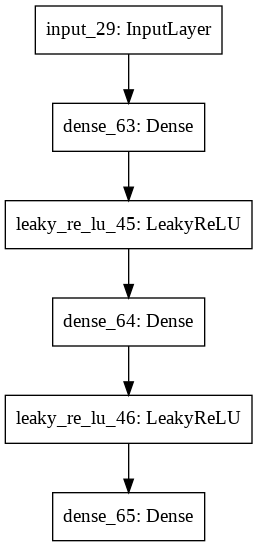

In [250]:
### Define the discriminator!
#############################

# We still use FUNCTIONAL API!

# The discriminator always gets (flattened) images as inputs
# Where can you find the flattened dimensions? 
# Please use a variable or property, not a hand "baked in" constant.
# That will mess up your life if the data changes...
d_input = Input(shape = (data.shape[1],))

# Following the design pattern from above, please implement two layers with nonlinearities!
### 1 layer
d_layer_1 =  Dense(DISCRIMINATOR_L1_DIM, activation=None)(d_input)
d_layer_1_nonlin =  LeakyReLU(alpha=LEAKY_ALPHA)(d_layer_1)

### 2 layer
d_layer_2 =  Dense(DISCRIMINATOR_L2_DIM, activation=None)(d_layer_1_nonlin)
d_layer_2_nonlin =  LeakyReLU(alpha=LEAKY_ALPHA)(d_layer_2)

###########################################################################
# Please implement the output layer!
# The output of the discriminator is a single binary decision, 
# so one use an appropriate activation and dimensionality!
d_output_layer = Dense(1, activation='sigmoid')(d_layer_2_nonlin)

###########################################################################
# Please instantiate the model!
discriminator = Model(d_input, d_output_layer)

# Please remeber, that the loss for the discriminator will be a binary loss, so this applies here also
# Use the appropriate loss measure!
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
discriminator.summary()
plot_model(discriminator)

### Joint model

In [251]:
### Define the GAN itself!
##########################

# STOP!!!!!!
# This is a crucial line, since in the joint model, discriminator will be frozen, so no weight update!
discriminator.trainable = False
# Remove this .... if you understand, why the above line is here!

# What is the input for the whole GAN?
# Think about the case, when the generator generates, the discriminator only discriminates it's output!
gan_input = Input(shape=[Z_DIM,])

# Use the generator as a function on the input!
generated_image = generator(gan_input)

# Use the discriminator as a function on the fake images!
gan_output = discriminator(generated_image)

# Instantiate the joint model, appropriate input and output!
joint_model = Model(inputs = gan_input,outputs = gan_output) 

# Please think about, why it can be true, that for the joint model a binary decision is still adequate!
joint_model.compile(loss='binary_crossentropy', optimizer=optimizer)
# Maybe it will get clear below in the training loop...

## Helper functions for visualization

In [252]:
# Nothing to see here! :-P

from matplotlib import pyplot as plt
import matplotlib.image as mpimg


def get_example_images(epoch, example_count=25):
    input_noise = np.random.normal(0,1, size=(example_count,Z_DIM))
    generated_images = generator.predict(input_noise)
    generated_images = generated_images.reshape(example_count, 28, 28)
    
    plt.figure(figsize = (5, example_count // 5))
    for ex in range(example_count):
        plt.subplot(5, example_count//5, ex+1)
        plt.imshow(generated_images[ex], interpolation="nearest", cmap="gray")
        plt.axis("off")
    plt.tight_layout()
    plt.savefig("example_images_epoch_num_{0}.png".format(epoch))

def show_image_for_epoch(epoch):
    imgname = "example_images_epoch_num_"+str(epoch)+".png"
    img = mpimg.imread(imgname)
    imgplot = plt.imshow(img)
    plt.show()


## Training

Sadly, we can not use simple `fit()`, but have to construct the main training loop ourselves.

100%|██████████| 350/350 [00:55<00:00,  6.34it/s]


Epoch number: 0 discriminator_loss: 0.6428079319425991 generator_loss: 0.9781709598643439


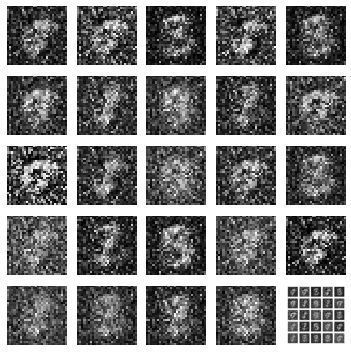

100%|██████████| 350/350 [00:53<00:00,  6.56it/s]


Epoch number: 1 discriminator_loss: 0.6425844305753707 generator_loss: 1.0755890876906258


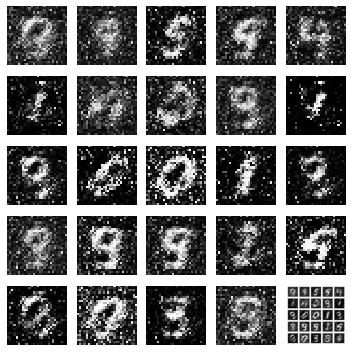

100%|██████████| 350/350 [00:53<00:00,  6.52it/s]


Epoch number: 2 discriminator_loss: 0.6089162160669054 generator_loss: 1.173248598234994


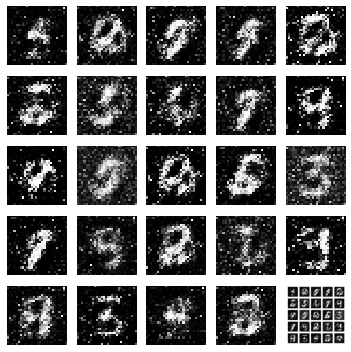

100%|██████████| 350/350 [00:53<00:00,  6.55it/s]


Epoch number: 3 discriminator_loss: 0.5742034716265542 generator_loss: 1.2905584086690631


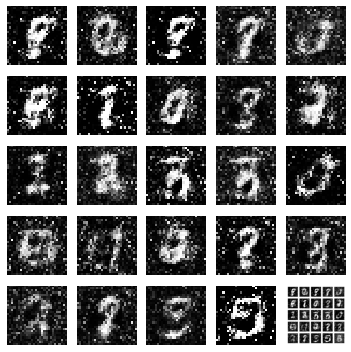

100%|██████████| 350/350 [00:53<00:00,  6.49it/s]


Epoch number: 4 discriminator_loss: 0.5668189721448081 generator_loss: 1.2973526634488788


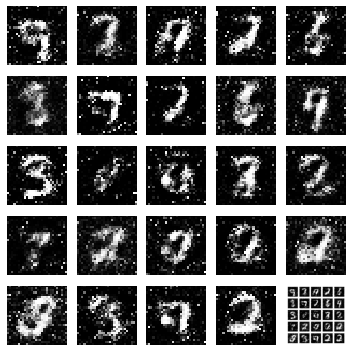

100%|██████████| 350/350 [00:53<00:00,  6.58it/s]


Epoch number: 5 discriminator_loss: 0.6043687697819301 generator_loss: 1.1790991469791958


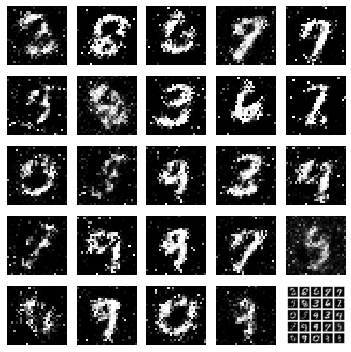

100%|██████████| 350/350 [00:54<00:00,  6.46it/s]


Epoch number: 6 discriminator_loss: 0.6168322581478528 generator_loss: 1.1240133476257324


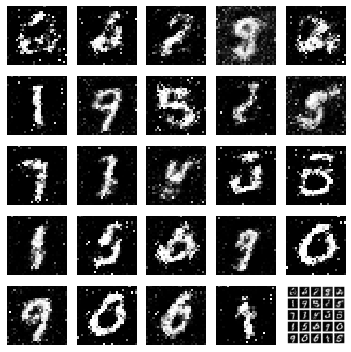

100%|██████████| 350/350 [00:53<00:00,  6.59it/s]


Epoch number: 7 discriminator_loss: 0.6279469699519021 generator_loss: 1.0839981814793178


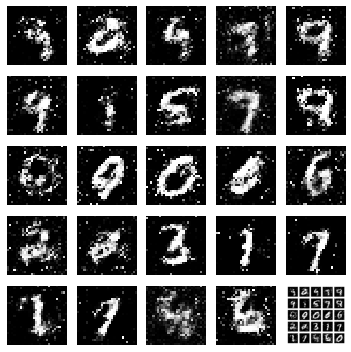

100%|██████████| 350/350 [00:53<00:00,  6.52it/s]


Epoch number: 8 discriminator_loss: 0.6434731607351984 generator_loss: 1.0351904807771954


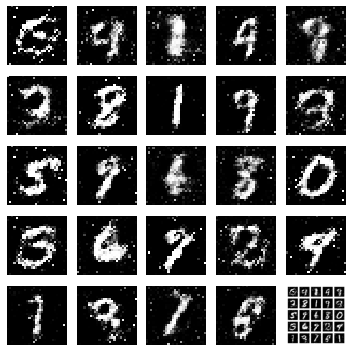

100%|██████████| 350/350 [00:53<00:00,  6.56it/s]


Epoch number: 9 discriminator_loss: 0.6444739790047918 generator_loss: 1.0301223347868238


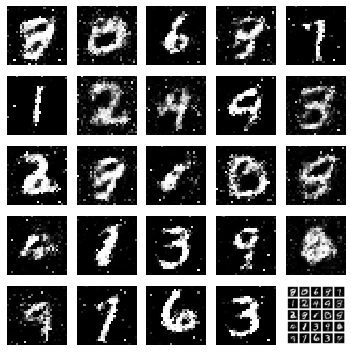

100%|██████████| 350/350 [00:53<00:00,  6.57it/s]


Epoch number: 10 discriminator_loss: 0.6465224516817502 generator_loss: 1.0202587475095477


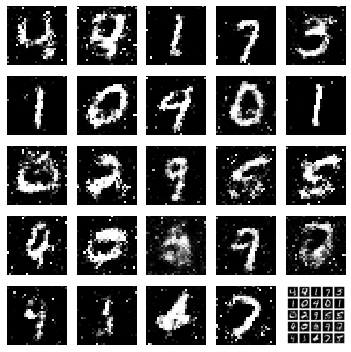

100%|██████████| 350/350 [00:53<00:00,  6.54it/s]


Epoch number: 11 discriminator_loss: 0.6456829120857375 generator_loss: 1.0290163690703256


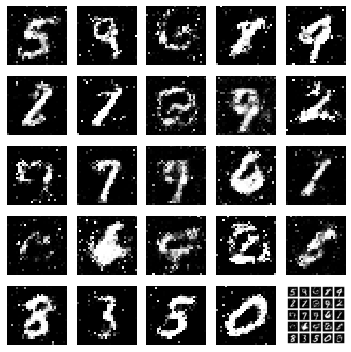

100%|██████████| 350/350 [00:53<00:00,  6.52it/s]


Epoch number: 12 discriminator_loss: 0.6488290361421449 generator_loss: 1.0226076332160405


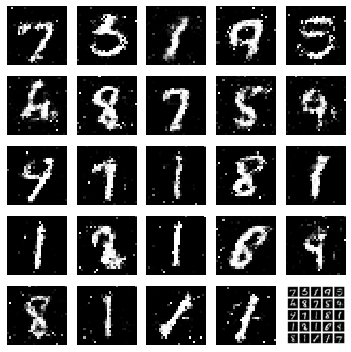

100%|██████████| 350/350 [00:53<00:00,  6.50it/s]


Epoch number: 13 discriminator_loss: 0.6504368175779071 generator_loss: 1.027351255587169


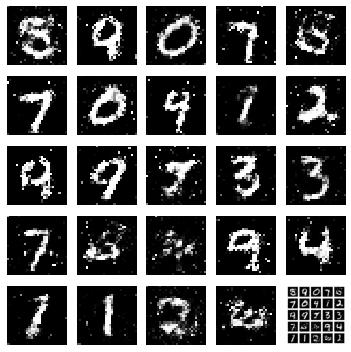

100%|██████████| 350/350 [00:53<00:00,  6.50it/s]


Epoch number: 14 discriminator_loss: 0.6481438492877143 generator_loss: 1.0255510221208846


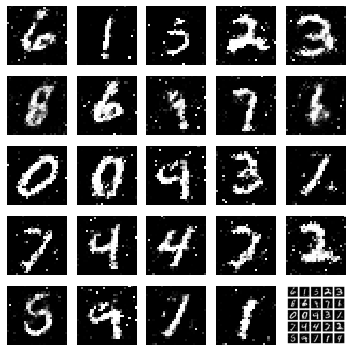

100%|██████████| 350/350 [00:53<00:00,  6.60it/s]


Epoch number: 15 discriminator_loss: 0.6469294387953622 generator_loss: 1.0350067164216723


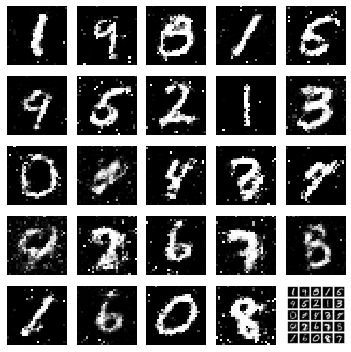

100%|██████████| 350/350 [00:53<00:00,  6.56it/s]


Epoch number: 16 discriminator_loss: 0.6483891585043499 generator_loss: 1.029038769687925


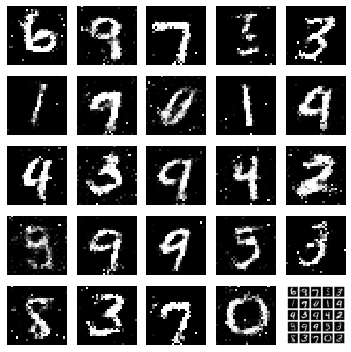

100%|██████████| 350/350 [00:53<00:00,  6.54it/s]


Epoch number: 17 discriminator_loss: 0.6521258720755577 generator_loss: 1.0190156594344548


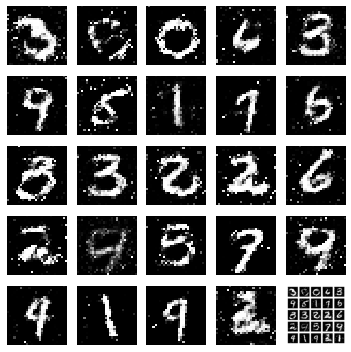

100%|██████████| 350/350 [00:54<00:00,  6.42it/s]


Epoch number: 18 discriminator_loss: 0.6533948328239577 generator_loss: 1.0215929245948792


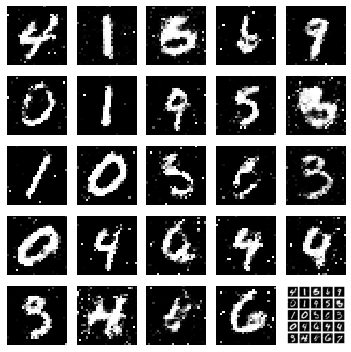

100%|██████████| 350/350 [00:53<00:00,  6.54it/s]


Epoch number: 19 discriminator_loss: 0.6556418832285064 generator_loss: 1.0139460725443703


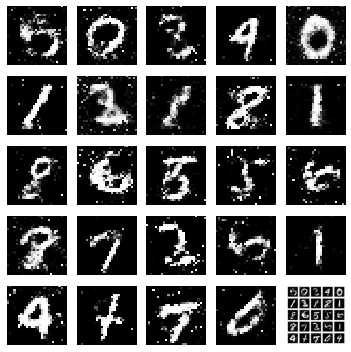

100%|██████████| 350/350 [00:53<00:00,  6.52it/s]


Epoch number: 20 discriminator_loss: 0.6565878513029644 generator_loss: 1.0140778720378876


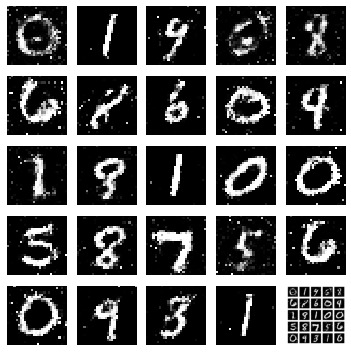

100%|██████████| 350/350 [00:54<00:00,  6.47it/s]


Epoch number: 21 discriminator_loss: 0.6580083793401719 generator_loss: 1.0081970751285554


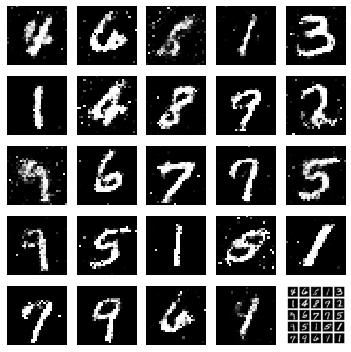

100%|██████████| 350/350 [00:54<00:00,  6.47it/s]


Epoch number: 22 discriminator_loss: 0.6585559683186667 generator_loss: 1.0080184750897543


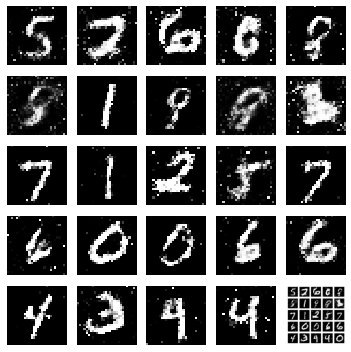

100%|██████████| 350/350 [00:54<00:00,  6.48it/s]


Epoch number: 23 discriminator_loss: 0.6584357751693044 generator_loss: 1.009876356635775


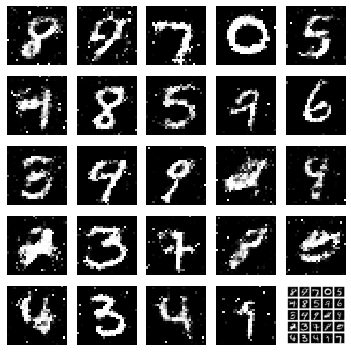

100%|██████████| 350/350 [00:54<00:00,  6.37it/s]


Epoch number: 24 discriminator_loss: 0.6593414555277143 generator_loss: 1.0082759034633637


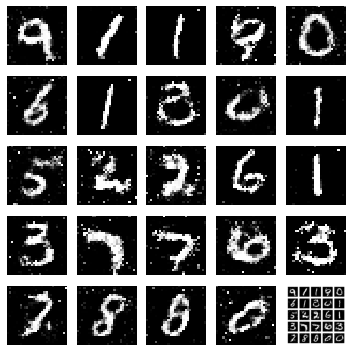

100%|██████████| 350/350 [00:54<00:00,  6.43it/s]


Epoch number: 25 discriminator_loss: 0.6622917587416512 generator_loss: 1.0026261516979762


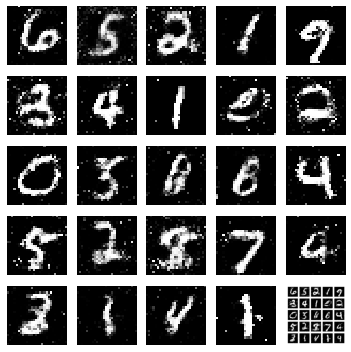

100%|██████████| 350/350 [00:54<00:00,  6.43it/s]


Epoch number: 26 discriminator_loss: 0.6617079166003635 generator_loss: 0.9994818413257599


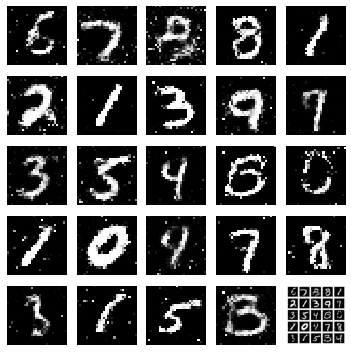

100%|██████████| 350/350 [00:54<00:00,  6.43it/s]


Epoch number: 27 discriminator_loss: 0.660339908514704 generator_loss: 1.0060057808671679


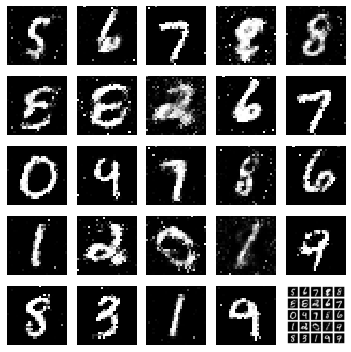

100%|██████████| 350/350 [00:54<00:00,  6.43it/s]


Epoch number: 28 discriminator_loss: 0.6618501434581621 generator_loss: 1.001226899623871


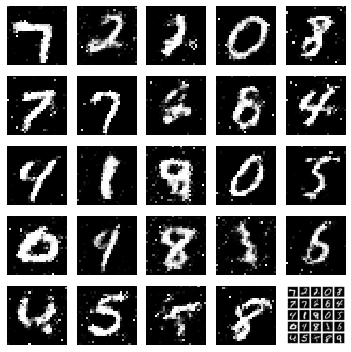

100%|██████████| 350/350 [00:54<00:00,  6.41it/s]


Epoch number: 29 discriminator_loss: 0.661643310700144 generator_loss: 1.0069072001320976


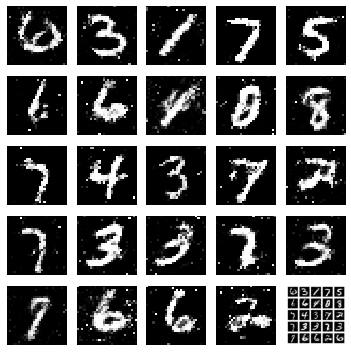

CPU times: user 38min 19s, sys: 1min 10s, total: 39min 30s
Wall time: 27min 26s


In [253]:
%%time
# To see some progress, we use tqdm as a progress bar
from tqdm import tqdm

# Since we do NOT use fit
# sadly, we have to do this ourselves manually
history = {"discriminator":[],"generator":[]}

with tf.device('/gpu:0' and '/gpu:1'):
    # Main training loop
    for epoch_num in range(EPOCHS):
        epoch_discriminator_loss = 0
        epoch_generator_loss = 0
        
        for batch in tqdm(range(BATCH_NUM)):
            # We select randomly a half batch amount of real images from MNIST
            # Use Numpy to choose, no replacement!
            real_images = data[np.random.choice(range(0,data.shape[0]),size = HALF_BATCH, replace= False)]

            # We generate a half batch amount of fake images
            # By first generating a half batch worth of Gaussian noise with zero mean, unit variance
            # and appropriate noise dimensions
            input_noise = np.random.normal(0,1,size=(HALF_BATCH,Z_DIM))

            # And then using the fixed generator, to output some images from it
            # Using the predict method of the generator!
            generated_images = generator.predict(input_noise)
            
            # STOP, and thik through, WHY predict?!
            ## Because we want to predict with the help of Generator , get the loss amd then discriminate to calculate losses
            # Then you can remove the (removed)
            
            # We generate our "labels"
            # Remember one sided label smoothing for the positive class!
            # Let's say with 0.9...
            # So please, generate a half batch sized, one dimensional matrix with ones, using numpy
            # and multiuply it by 0.9
            real_y = np.ones(HALF_BATCH) * 0.9

            # And generate a half batch worth of zeroes, again one dimensional matrix
            generated_y = np.zeros(HALF_BATCH)

            
            ### We do the actual training!
            # First for the discriminator on the real data
            discriminator_loss_real = discriminator.train_on_batch(real_images, real_y)
            
            # Then on the fake data
            discriminator_loss_generated = discriminator.train_on_batch(generated_images, generated_y)
            
            # Then average the two losses
            discriminator_loss = (discriminator_loss_real + discriminator_loss_generated) / 2
            epoch_discriminator_loss += discriminator_loss
            
            ### We then update the generator
            # We use the discriminator that was trained a line above, and is frozen, as defined in the joint model
            
            # Please generate a new set of input noise, notice, it is a full batch!
            # Again, using numpy, normal distribution, zero mean, unit variance
            new_input_noise = np.random.normal(0,1,size=(BATCH_SIZE,Z_DIM))
            
            # We try to convince the discriminator, that this is real data - which is not
            # So please generate a batch worht of one dimensional matrix filled with ones 
            convincing_y = np.ones(BATCH_SIZE)
            # Notice, no label smoothing!

            # Remember, the joint model takes in noise, does the generation, the discrimination, then computes loss
            # But the discriminator is frozen, so only the generator will get updated
            # It is "successful" if the discriminator predicts "real" - hence the convincing_y
            generator_loss = joint_model.train_on_batch(new_input_noise, convincing_y)
            epoch_generator_loss += generator_loss
            
        # Loss printout in every epoch, averaged over the batches
        print("Epoch number:",epoch_num,"discriminator_loss:",epoch_discriminator_loss / BATCH_NUM, "generator_loss:", epoch_generator_loss / BATCH_NUM)
        
        # Save it for the future
        history["discriminator"].append(epoch_discriminator_loss / BATCH_NUM)
        history["generator"].append(epoch_generator_loss / BATCH_NUM)
        
        #Save model - optional
        #generator.save("generator.h5")
        
        #Save images
        get_example_images(epoch_num)
        
        # Show epoch example
        show_image_for_epoch(epoch_num)

## Visualization of training progress

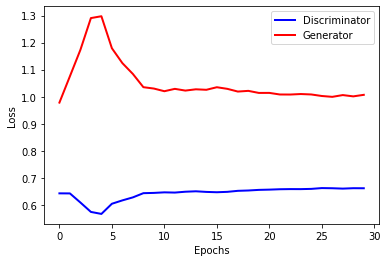

In [255]:
plt.plot(history["discriminator"], color='blue', linewidth=2, label="Discriminator")
plt.plot(history["generator"],  color='red', linewidth=2, label="Generator")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();


There has been a fluctuation in losses of training and after **epochs > 10** the discriminative losses stabilises.